# Automatic peak finding and calibration tools in Becquerel

`Becquerel` contains tools for obtaining a rough first calibration for an uncalibrated `Spectrum`.

First, some imports:

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import becquerel as bq

Also some function definitions:

In [2]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()


def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))

    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))

## `PeakFilter` classes

Instances of `PeakFilter` classes generate energy-dependent kernels that can be convolved with a spectrum to extract lines from the background continuum. To instantiate a kernel, the FWHM in channels at a specific channel is required, and the kernel scales the FWHM so that it is proportional to the square root of the channel (approximating the energy resolution of a detector).

Here is what a `BoxcarPeakFilter` and `GaussianDerivPeakFilter` look like:

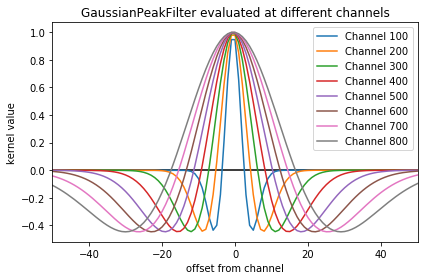

In [3]:
# demonstrate energy-dependent kernels
channels = np.arange(1000)
for kernel in [bq.GaussianPeakFilter(1000, 50, 5)]:
    plt.figure()
    plt.title('{} evaluated at different channels'.format(type(kernel).__name__))
    ind = np.arange(1000)

    plt.plot([-50, 50], [0, 0], 'k-')
    for chan in range(100, 900, 100):
        kern = kernel.kernel(chan, np.arange(1001))
        plt.plot(ind - chan, kern, '-', lw=1.5, label='Channel {}'.format(chan))
    plt.xlim(-50, 50)
    plt.xlabel('offset from channel')
    plt.ylabel('kernel value')
    plt.legend()
    plt.tight_layout()

We will use the `GaussiaPeakKernel` from now on.

A kernel can create a matrix that can be multiplied with a spectrum to perform the convolution. Here is what such a matrix could look like:

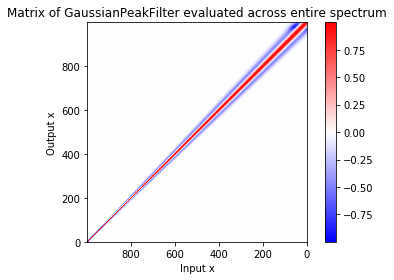

In [4]:
# display the kernel matrix
kernel = bq.GaussianPeakFilter(1000, 50, 5)

plt.figure()
plt.title('Matrix of GaussianPeakFilter evaluated across entire spectrum')
kernel.plot_matrix(np.arange(1000))
plt.tight_layout()

## `PeakFinder` and `AutoCalibrator` classes

The `PeakFinder` class allows one to automatically select peaks that a `PeakFilter` filters out of the spectrum.

The `AutoCalibrator` class takes the peaks found by a `PeakFinder` and finds the most likely energies associated with those peaks.

It is easiest to explain these classes using examples.

## Example 1: Calibrating a scintillator spectrum

First we read in a raw spectrum from file (this is a simulated background spectrum for a scintillator):

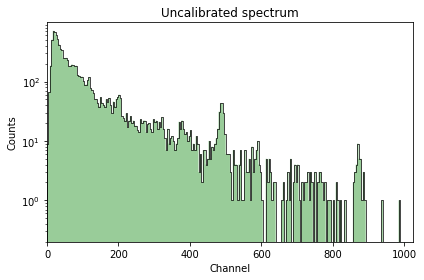

In [5]:
counts = []
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/sim_spec.csv')
with open(filename, 'r') as f:
    for line in f:
        tokens = line.strip().split(',')
        if len(tokens) == 2:
            counts.append(float(tokens[1]))
spec = bq.Spectrum(counts=counts)
spec = spec.combine_bins(4)
spec.bin_edges_raw *= 4
plot_spec(spec)

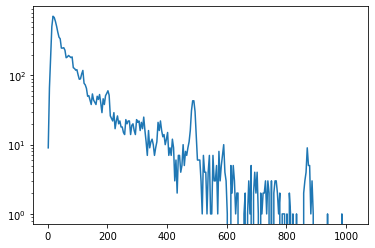

In [6]:
plt.figure()
plt.plot(spec.bin_centers_raw, spec.counts_vals)
plt.yscale('log')
plt.show()

To filter this spectrum we will use a kernel with a width of 50 channels at 500 channels, to match the strong line in the center (most likely the K-40 line at 1460 keV):

In [7]:
kernel = bq.GaussianPeakFilter(500, 50, fwhm_at_0=10)

### 1.1 `PeakFinder` class

The `PeakFinder` class uses a `PeakFilter` to filter and calibrate the spectrum.

Under the hood, the kernel estimates the SNR of each peak by separating peaks from the background continuum. We can introspect this process using the `PeakFinder` instance:

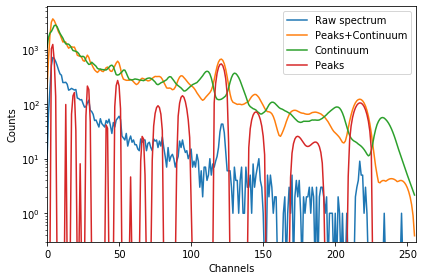

In [8]:
# show how the kernel estimates the peaks+background and the background
finder = bq.PeakFinder(spec, kernel)

plt.figure()
plt.plot(spec.counts_vals.clip(1e-1), label='Raw spectrum')
plt.plot(finder._peak_plus_bkg.clip(1e-1), label='Peaks+Continuum')
plt.plot(finder._bkg.clip(1e-1), label='Continuum')
plt.plot(finder._signal.clip(1e-1), label='Peaks')
plt.yscale('log')
plt.xlim(0, len(spec))
plt.ylim(3e-1)
plt.xlabel('Channels')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()

The kernel applied directly to the spectral count data produces the estimated signal-to-noise (SNR) of each peak.

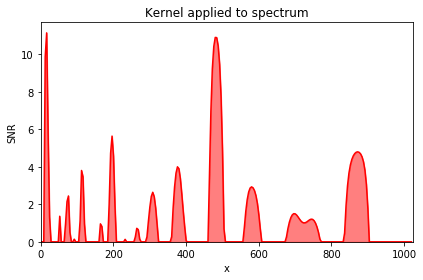

In [9]:
# plot signal to noise
plt.figure()
plt.title('Kernel applied to spectrum')
finder.plot()
plt.tight_layout()

### 1.2 Using `find_peak` to find a specific peak

Use the method `find_peak` to find a specific peak in the spectrum.

Let's try to locate the index of the tallest peak, right in the middle of the spectrum:

480.0


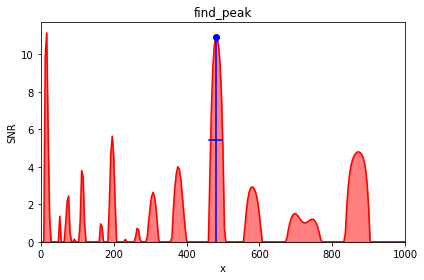

In [15]:
peak_chan = finder.find_peak(500, min_snr=3.)
print(peak_chan)

plt.figure()
plt.title('find_peak')
finder.plot()
plt.xlim(0,1000)
plt.tight_layout()

In [16]:
finder.channels

[480.0]

Subsequent calls to `find_peak` will store the any new results:

872.0


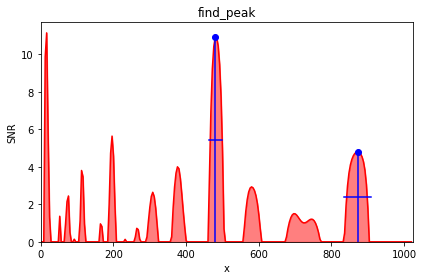

In [17]:
peak_chan = finder.find_peak(900, min_snr=3.)
print(peak_chan)

plt.figure()
plt.title('find_peak')
finder.plot()
plt.tight_layout()

#### 1.2 Use `reset` to remove all candidate peaks and calibration data

The list of candidate peaks will persist in the `PeakFinder` object, as will any calibration information (will be covered later).

Resetting the current object yields:

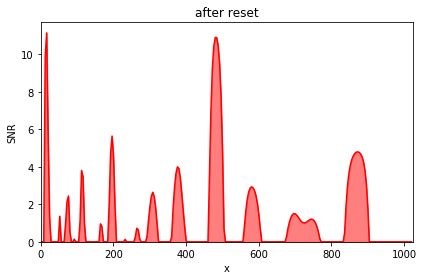

In [18]:
finder.reset()

plt.figure()
plt.title('after reset')
finder.plot()
plt.tight_layout()

### 1.2 Using `find_peaks` to find all peaks above an SNR threshold

Instead of repeatedly calling `find_peak`, one can build up a set of peak candidates using `find_peaks`. The following locates all peaks above channel 50 and an SNR of 2:

[52.0, 72.0, 112.0, 192.0, 304.0, 376.0, 480.0, 580.0, 696.0, 744.0, 868.0]
[1.3634798548337108, 2.1440119793781354, 3.803283011205457, 4.722618772638548, 2.4223363472524673, 3.99879142301986, 10.896650919548449, 2.930125481801924, 1.5009285268312171, 1.2079681273760376, 4.7754873541141665]


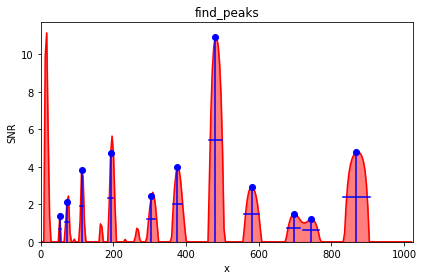

In [19]:
finder.find_peaks(min_snr=1, xmin=50)
print(finder.channels)
print(finder.snrs)

plt.figure()
plt.title('find_peaks')
finder.plot()
plt.tight_layout()

### 1.4 The `AutoCalibrator.fit` method

The main machinery of auto-calibration is the `fit` method, which matches peak candidates (e.g., the outputs of `find_peaks`) with specific line energies and keeps the best match:

found best gain: 3.038400 keV/channel
fit gain: 3.0383996548315237 keV/channel
fit channels: [ 72. 112. 192. 304. 376. 480. 580. 696. 868.]


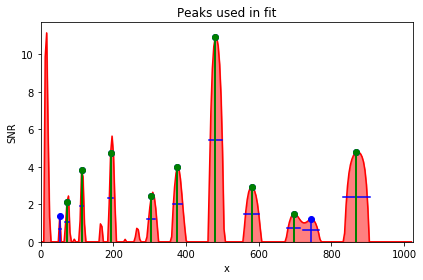

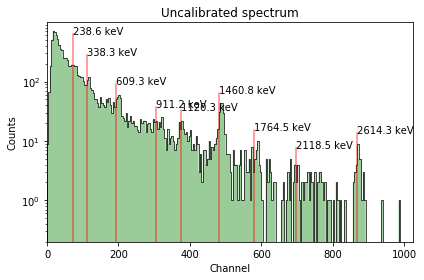

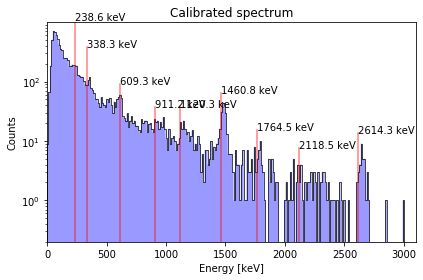

In [20]:
cal = bq.AutoCalibrator(finder)
cal.fit(
    [609.32, 1460.82, 2614.3],
    optional=[238.63, 338.32, 351.93, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[2.5e-2, 4e2],
    de_max=200.,
)
plot_calibrator(cal)

### 1.5 `AutoCalibrator.fit` with only one peak

A special case of the calibrator is when only one peak has been found and only one energy is given. Use this with caution since there is none of the cross-validation that comes with multiple lines.

fit gain: 3.0433749999999997 keV/channel
fit channels: [480.0]


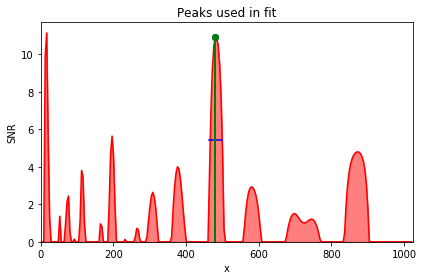

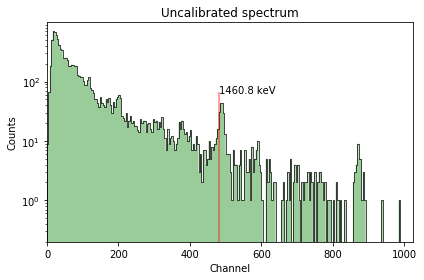

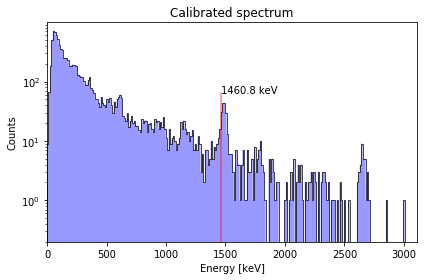

In [21]:
cal.peakfinder.reset()
cal.peakfinder.fwhm_tol=(0.5, 1.2)
cal.peakfinder.find_peak(500, min_snr=3.)
cal.fit([1460.82], gain_range=[2.5e-1, 4e1], de_max=50.)
plot_calibrator(cal)

## Example 2: Calibrating an HPGe spectrum

Let's perform the same calibration steps using an HPGe spectrum. This spectrum will have many more lines to fit.

SpeFile: Reading file /Users/jvavrek/becquerel/becquerel/../tests/samples/Mendocino_07-10-13_Acq-10-10-13.Spe


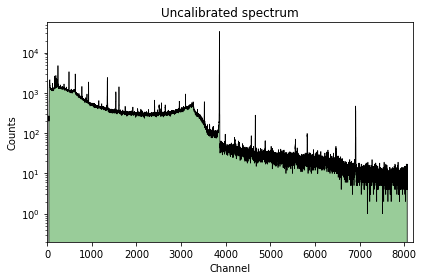

In [17]:
# read raw HPGe data
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/Mendocino_07-10-13_Acq-10-10-13.Spe')
spec = bq.Spectrum.from_file(filename)
plot_spec(spec)

We will again use a `GaussianDerivKernel`, but this one must be much narrower to match the resolution. Not surprisingly, the peaks in the spectrum have much higher SNR values:

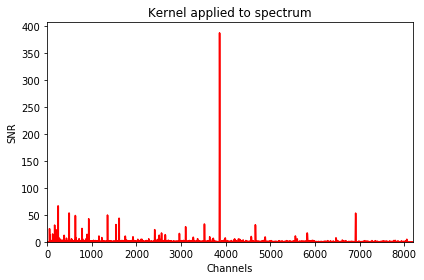

In [20]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

plt.figure()
plt.title('Kernel applied to spectrum')
cal.peakfinder.plot()
plt.tight_layout()

[490.0, 629.0, 779.0, 929.0, 1349.0, 1540.0, 1609.0, 2407.0, 2560.0, 2960.0, 3099.0, 3520.0, 3859.0, 4661.0, 5823.0, 6907.0]
[53.49800511558122, 41.16520695971113, 24.830972327324112, 42.781061301836885, 48.33032914532712, 32.085820134100594, 43.01445367044275, 22.592051287390117, 16.456977852810972, 15.592691470289916, 27.095990649503538, 33.13143504681022, 385.9445836649352, 30.916153909758677, 16.451689394465326, 52.83293730718468]


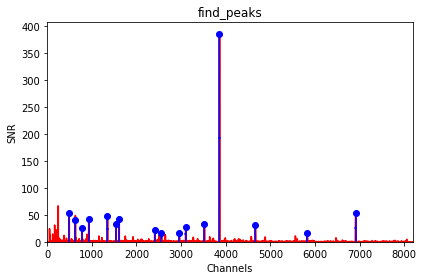

In [21]:
# find significant peaks
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.channels)
print(cal.peakfinder.snrs)

plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.378550 keV/channel
fit gain: 0.3785503128558726 keV/channel
fit channels: [ 629.  929. 1609. 2407. 2960. 3859. 4661. 6907.]
630 630
929 929
1609 1609
2407 2407
2959 2959
3858 3858
4661 4661
6906 6906


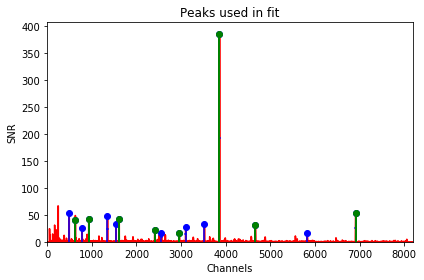

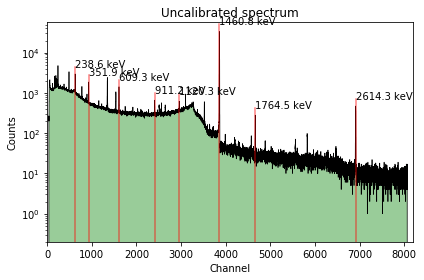

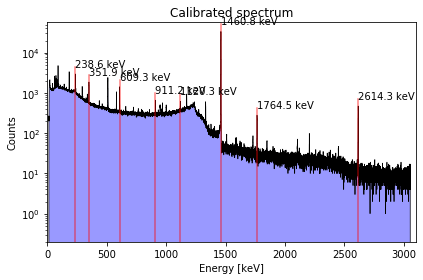

In [22]:
# perform calibration
cal.fit(
    [238.63, 351.93, 609.32, 1460.82, 2614.3],
    optional=[338.32, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 0.4],
    de_max=5.,
)
plot_calibrator(cal)

## Example 3: An unusual NaI spectrum

This example shows a real spectrum from a NaI detector with very poor energy resolution and where the dynamic range has cut off the higher energies. Can we still calibrate it?

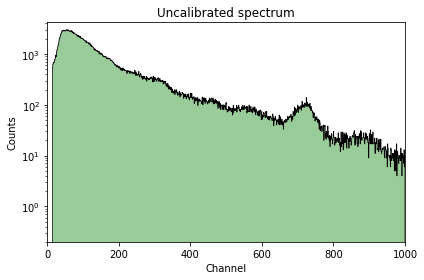

In [23]:
counts = []
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/nai_detector.csv')
with open(filename, 'r') as f:
    for line in f:
        tokens = line.strip().split(',')
        if len(tokens) == 2:
            counts.append(float(tokens[1]))
spec = bq.Spectrum(counts=counts)
plot_spec(spec)

[118.0, 175.0, 322.0, 462.0, 561.0, 720.0, 879.0]
[3.1504234886798974, 4.322861684939302, 5.200473611414463, 5.397054299628207, 4.600858394575645, 26.615476679342716, 4.225961409423594]


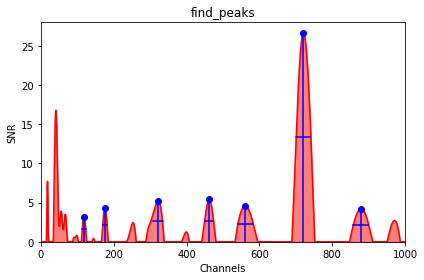

In [25]:
kernel = bq.GaussianPeakFilter(700, 50, 10)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

# find significant peaks
cal.peakfinder.find_peaks(min_snr=3, xmin=100)
print(cal.peakfinder.channels)
print(cal.peakfinder.snrs)

plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 3.224485 keV/channel
fit gain: 3.224485210730536 keV/channel
fit channels: [175. 462.]
188 188
453 453


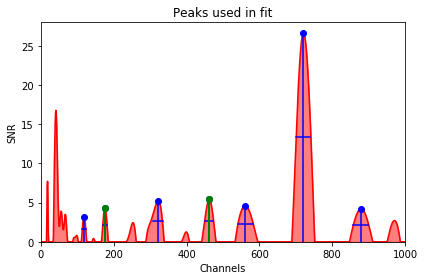

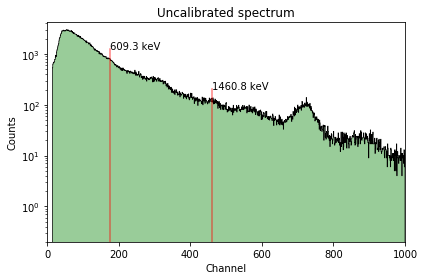

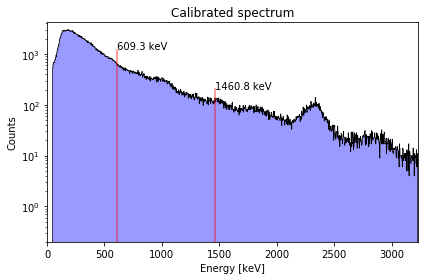

In [26]:
# perform calibration
cal.fit(
    [609.32, 1460.82],
    optional=[],
    gain_range=[0.1, 5.],
    de_max=50.,
)
plot_calibrator(cal)

That did not work right, the calibrator matched with the wrong lines. To fix this, we could either increase `xmin` to exclude the lower energy lines, increase `min_snr` to exclude the lower significance lines, or add optional energies. Let's try the same fit but with a longer list of prominent background lines:

found best gain: 2.024068 keV/channel
fit gain: 2.024068335161172 keV/channel
fit channels: [118. 175. 322. 462. 561. 720. 879.]


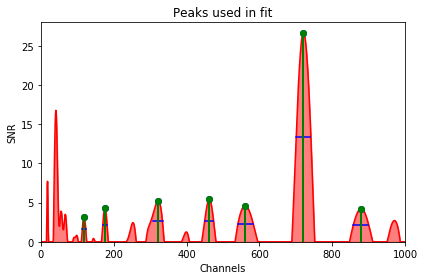

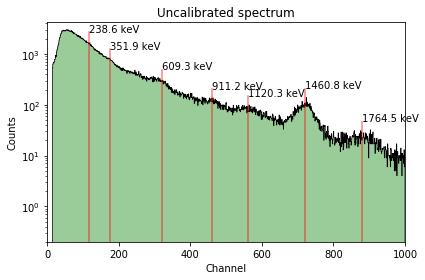

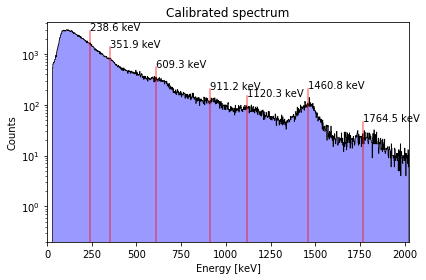

In [29]:
# perform calibration again, but with more optional energies
cal.fit(
    [609.32, 1460.82],
    optional=[238.63, 338.32, 351.93, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.1, 5.],
    de_max=50.,
)
plot_calibrator(cal)

Success! The cross-validation used in `AutoCalibrator.fit` was able to find a better match.

## Example 4: CsI detector with Ba-133 and Cs-137 sources

This data is from a small detector with Ba-133 and Cs-137 sources near it. We want to use those sources' lines and any strong backgroud lines to calibrate it.

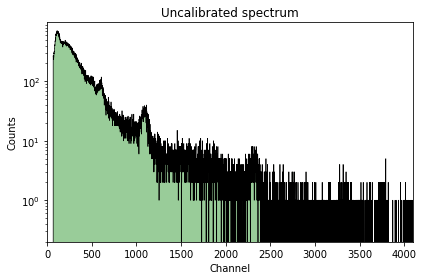

In [30]:
counts = []
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/SGM102432.csv')
with open(filename, 'r') as f:
    for line in f:
        tokens = line.strip().split(',')
        if len(tokens) == 2:
            counts.append(float(tokens[1]))
spec = bq.Spectrum(counts=counts)
plot_spec(spec)

[108.0, 508.0, 601.0, 1093.0, 2314.0, 3327.0, 3747.0]
[27.143687050865427, 4.5443470955954055, 12.383123804810953, 14.080678581354638, 9.618639619219902, 3.3004472156615106, 5.081491231060224]


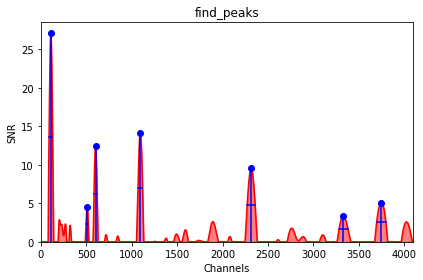

In [32]:
kernel = bq.GaussianPeakFilter(2400, 120, 30)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

# find significant peaks
cal.peakfinder.find_peaks(min_snr=3, xmin=100)
print(cal.peakfinder.channels)
print(cal.peakfinder.snrs)

plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.613688 keV/channel
fit gain: 0.6136877718024971 keV/channel
fit channels: [ 601. 1093. 2314.]


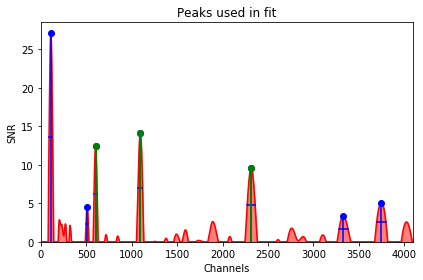

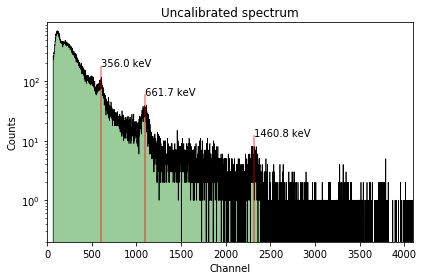

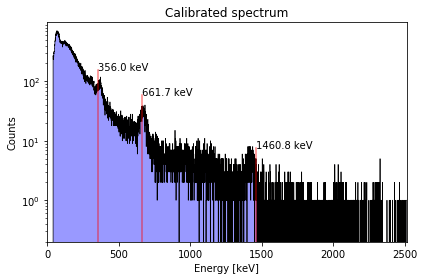

In [33]:
cal.fit(
    [356.0129, 661.657, 1460.82],
    optional=[911.20, 1120.294, 1620.50, 1764.49, 2118.514, 2614.3, 2118.514],
    gain_range=[0.3, 0.7],
    de_max=50.,
)
plot_calibrator(cal)

This last plot reveals that the 1460 keV peak does not quite line up with the calibration, so this detector probably exhibits a significant nonlinearity and would have to be calibrated with a more sophisticated method.